## Analysis of Merged Data Frame (descriptive statistics, regression analyses,etc.)


Setting up the environment and importing the merged data set and the merged data set with the indexed data:

In [1]:
# Import merged data frame

import pandas as pd

pd.set_option('display.max.rows', None)
pd.set_option('display.max.columns', None)

indexed_data_filtered = pd.read_csv(
    r"C:\Users\jhummels\OneDrive - DIW Berlin\Gehlen, Annica's files - retirement-labor-shortages\Data\complete_data_frame_indexed.csv"
)
filtered_merged = pd.read_csv(
    r"C:\Users\jhummels\OneDrive - DIW Berlin\Gehlen, Annica's files - retirement-labor-shortages\Data\complete_data_frame.csv"
)

Outputting the correlation matrix of the data frame for the aggregate data and for each berufsgruppe: 

In [ ]:
####################################################################################
# Plot the correlation heatmap 
####################################################################################

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix for the entire subset
corr_matrix = filtered_merged.drop(columns=['Beruf', 'source_file', 'haupttask']).corr()

# Create a triangular mask for the heatmap
trimask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, mask=trimask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Overall Correlation Matrix Heatmap (_indexed columns)", fontsize=16)
plt.tight_layout()
plt.show()

####################################################################################
# Output the correlation matrix as a heatmap for each Beruf group
####################################################################################


# Loop over each Beruf group
for beruf_name, group in filtered_merged.groupby("kldb2010_3_akvs"):
    
    # Only select numeric columns
    numeric_cols = group.select_dtypes(include=["number"])
    
    if numeric_cols.shape[1] < 2:
        # Skip if there's not enough numeric data to calculate correlations
        continue

    # Calculate correlation matrix
    corr_matrix = numeric_cols.corr()
    # Create a triangular mask for the heatmap
    trimask = np.triu(np.ones_like(corr_matrix, dtype=bool))


    # Plot
    plt.figure(figsize=(30, 30))
    sns.heatmap(corr_matrix, mask=trimask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title(f"Correlation Heatmap for Beruf: {beruf_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

Here I plot the time series graph for a specific Berufsgruppe (in this case Industrie and Handel) for 3 different variables, the ratio_mean which is the mean of the labor market tightness indicator (V/S), the abgeschlossene Vakanzzeit in Tagen and the share of people in rente_beslang. The visualization can be applied to every berufsgruppe in the data frame by changing the number for beruf_code. 

In [ ]:
####################################################################################
# Visualize the data for a specific Beruf (e.g., 'Industrie und handel' with kldb2010_3_akvs = 611)
####################################################################################
import matplotlib.pyplot as plt

# 1. Filter the data for the specific 'kldb2010_3_akvs' value
beruf_code = 211  # Industrie und handel (replace if needed)
handel = filtered_merged[filtered_merged['kldb2010_3_akvs'] == beruf_code]

# 2. Group by 'year' and 'bland' and calculate the mean for all relevant variables at once
# Specify the variables you want to plot
variables_to_plot = ['ratio_mean', 'abgesch_Vakanzzeit_Tage', 'rente_beslang']

# Group and calculate mean for those variables
einkauf_grouped = handel.groupby(['year', 'bland'])[variables_to_plot].mean().reset_index()

# 3. Loop over each variable and plot
for variable in variables_to_plot:
    plt.figure(figsize=(12, 8))
    for bland in einkauf_grouped['bland'].unique():
        subset = einkauf_grouped[einkauf_grouped['bland'] == bland]
        plt.plot(subset['year'], subset[variable], marker='o', label=f'Bundesland {bland}')

    # Add titles, labels, and legend
    plt.title(f'{variable} Over Time by Bundesland for Beruf {beruf_code}', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(variable, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Bundesland', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()







Next, I build 5 different regression models in which I regress the log share of people in early retirement on the log of my labor markete tightness index. Each model has a different specification. The first models includes both a bundesland and berufsgruppen fixed effect and some control variables like the abgescheschlossene Vakanzzeit. The second model is the same but without the additional control variables but the fixed effects. The third model only includes a bundesland fixed effect, the fourth model only a berufsgruppen fixed effect and the last model no fixed effect. 

In [10]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Run regressions using log-transformed variables
model1 = smf.ols(
    'rente_beslang_log ~ ratio_mean_log + abgesch_Vakanzzeit_Tage_log + Arbeitslose_log + Zugang_log + rentner_log + alter_rentenzugang_log + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()

model2 = smf.ols(
    'rente_beslang_log ~ ratio_mean_log + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()

model3 = smf.ols(
    'rente_beslang_log ~ ratio_mean_log + C(bland)',
    data=indexed_data_filtered
).fit()

model4 = smf.ols(
    'rente_beslang_log ~ ratio_mean_log + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()

model5 = smf.ols(
    'rente_beslang_log ~ ratio_mean_log',
    data=indexed_data_filtered
).fit()

# Stargazer-style info dictionary
info_dict = {
    'R²': lambda x: f"{x.rsquared:.3f}",
    'N': lambda x: f"{int(x.nobs)}",
    'Bundesland FE': lambda x: 'Yes' if 'C(bland)' in x.model.formula else 'No',
    'Beruf FE': lambda x: 'Yes' if 'C(kldb2010_3_akvs)' in x.model.formula else 'No',
}

# List of variables to retain
main_vars = [
    'Intercept',
    'abgesch_Vakanzzeit_Tage_log',
    'abgesch_Vakanzzeit_Tage_log',
    'abgesch_Vakanzzeit_Tage_log',
    'Arbeitslose_log',
    'Arbeitslose_log',
    'Arbeitslose_log',
    'Zugang_log',
    'Zugang_log',
    'Zugang_log',
    'rentner_log',
    'alter_rentenzugang_log',
]

# Generate regression summary
results_table = summary_col(
    results=[model1, model2, model3, model4, model5],
    model_names=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"],
    stars=True,
    info_dict=info_dict,
)

# Clean up summary table
index = results_table.tables[0].index
mask = (~index.str.startswith('C(bland)', na=False)) & \
       (~index.str.startswith('C(kldb2010_3_akvs)', na=False)) & \
       (index != '') & \
       (index != ' ') & \
       (~index.str.fullmatch(r'\(.*\)', na=False))

results_table.tables[0] = results_table.tables[0][mask]

print(results_table)



                             Model 1    Model 2   Model 3   Model 4   Model 5 
------------------------------------------------------------------------------
Intercept                   12.1508*** 0.0934*** 0.0991*** 0.1088*** 0.1175***
ratio_mean_log              0.0550***  0.1168*** 0.1175*** 0.0753*** 0.1033***
abgesch_Vakanzzeit_Tage_log 0.0682***                                         
Arbeitslose_log             0.0083***                                         
Zugang_log                  -0.0083***                                        
rentner_log                 0.6516***                                         
alter_rentenzugang_log      -3.0312***                                        
R-squared                   0.8239     0.5458    0.1887    0.4365    0.0779   
R-squared Adj.              0.8212     0.5421    0.1879    0.4324    0.0779   
Beruf FE                    Yes        Yes       No        Yes       No       
Bundesland FE               Yes        Yes       Ye

The follow code gives a summary about the indexed data frame, including the column names, summary statistics, missing values and summary statistics for each berufsgruppe:

In [ ]:
# Descriptive statistics of the indexed data
####################################################################################
print(indexed_data_filtered.columns)
print(indexed_data_filtered.info())
print(indexed_data_filtered.describe())
print(indexed_data_filtered.isnull().sum())    
print(indexed_data_filtered.groupby("kldb2010_3_akvs").describe(include='all'))


The following code outputs the correlation heatmap for selected variables, including the labor market tightness indicator (ratio_mean), abgeschlosssene Vakanzzeit in Tagen, Anzahl der Ausbildungsstellen, Anteil der rente_lang, Anteil der rente_em, Alter bei Rentenzugang and Anteil in rente_beslang. The lag values are also included.

In [ ]:
# Subset the data to specific variables
####################################################################################

# Select the columns of interest and include 'kldb2010_3_akvs' for grouping
columns_of_interest = [
    'kldb2010_3_akvs',  # Include this column for grouping
    'ratio_mean', 'ratio_mean_lag1', 'ratio_mean_lag2', 'ratio_mean_lag3', 'ratio_mean_lag4',
    'abgesch_Vakanzzeit_Tage', 'abgesch_Vakanzzeit_Tage_lag1', 'abgesch_Vakanzzeit_Tage_lag2',
    'abgesch_Vakanzzeit_Tage_lag3', 'abgesch_Vakanzzeit_Tage_lag4',
    'Ausbildungsstellen_Anzahl', 'Ausbildungsstellen_Anzahl_lag1', 'Ausbildungsstellen_Anzahl_lag2',
    'Ausbildungsstellen_Anzahl_lag3', 'Ausbildungsstellen_Anzahl_lag4',
    'rente_lang', 'rente_em', 'alter_rentenzugang', 'rente_beslang'
    
]

# Create a new DataFrame with only the columns of interest
indexed_data_subset = indexed_data_filtered[columns_of_interest].copy()

# Plot the correlation heatmap for the subset
####################################################################################

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix for the entire subset
corr_matrix = indexed_data_subset.drop(columns=['kldb2010_3_akvs']).corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Overall Correlation Matrix Heatmap (_indexed columns)", fontsize=16)
plt.tight_layout()
plt.show()

# Define indexed columns for group-specific heatmaps
indexed_columns = [col for col in columns_of_interest if col != 'kldb2010_3_akvs']

# Loop over each Beruf group and plot group-specific correlation heatmaps
for beruf_name, group in indexed_data_subset.groupby("kldb2010_3_akvs"):
    
    # Select only the _indexed numeric columns from the group
    group_indexed = group[indexed_columns].select_dtypes(include=["number"])

    if group_indexed.shape[1] < 2:
        continue

    # Calculate correlation matrix for the group
    group_corr_matrix = group_indexed.corr()

    # Create a triangular mask for the heatmap
    trimask = np.triu(np.ones_like(group_corr_matrix, dtype=bool))

    # Plot
    plt.figure(figsize=(15, 15))
    sns.heatmap(group_corr_matrix, mask=trimask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
    plt.title(f"Correlation Heatmap for Beruf: {beruf_name}", fontsize=16)
    plt.tight_layout()
    plt.show()




Next, I run a couple more regressions but now using the lag values of my labor market tightness indicator. 

In [ ]:
# Regression Analysis of the lag data
####################################################################################
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Step : Run the regression on the cleaned data
model1 = smf.ols(
    'rente_beslang_log ~ ratio_mean + ratio_mean_lag1 + ratio_mean_lag2 + ratio_mean_lag3 + ratio_mean_lag4  + Arbeitslose_indexed_lag2 + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()

model2 = smf.ols(
    'rente_beslang_log ~ ratio_mean + ratio_mean_lag1 + ratio_mean_lag2 + ratio_mean_lag3 + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()

model3 = smf.ols(
    'rente_beslang_log ~ ratio_mean + ratio_mean_lag1 + ratio_mean_lag2 + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()

model4 = smf.ols(
    'rente_beslang_log ~ ratio_mean + ratio_mean_lag1 + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()



# Custom info_dict for stargazer-like output
info_dict = {
    'R²': lambda x: f"{x.rsquared:.3f}",
    'N': lambda x: f"{int(x.nobs)}",
    'Bundesland FE': lambda x: 'Yes' if 'C(bland)' in x.model.formula else 'No',
    'Beruf FE': lambda x: 'Yes' if 'C(kldb2010_3_akvs)' in x.model.formula else 'No',
}

main_vars = [
    'Intercept',
    'abgesch_Vakanzzeit_Tage_indexed',
    'abgesch_Vakanzzeit_Tage_indexed_lag1',
    'abgesch_Vakanzzeit_Tage_indexed_lag2',
    'Arbeitslose_indexed',
    'Arbeitslose_indexed_lag1',
    'Arbeitslose_indexed_lag2',
    'Zugang_indexed',
    'Zugang_indexed_lag1',
    'Zugang_indexed_lag2',
    'rentner_indexed',
    'alter_rentenzugang_indexed',
]

# Generate table
results_table = summary_col(
    results=[model1, model2, model3, model4, model5],
    model_names=["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"],
    stars=True,
    info_dict=info_dict,
)

# Remove dummy variables and blank rows (standard errors without corresponding variable)
index = results_table.tables[0].index
mask = (~index.str.startswith('C(bland)', na=False)) & \
       (~index.str.startswith('C(kldb2010_3_akvs)', na=False)) & \
       (index != '') & \
       (index != ' ') & \
       (~index.str.fullmatch(r'\(.*\)', na=False))  # matches rows like "(5.234)" etc.

results_table.tables[0] = results_table.tables[0][mask]

print(results_table)

print(results_table)


Here I plot the log of my labor market tightness index against the share of people in early retirement.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic scatterplot with regression line
sns.lmplot(
    x='ratio_mean_log', 
    y='rente_beslang_log', 
    data=indexed_data_filtered, 
    aspect=1.5, 
    line_kws={'color': 'red'}
)

plt.title('log(V/S) on rente_beslang_log')
plt.xlabel('log(V/S)')
plt.ylabel('rente_beslang_log')
plt.show()

Here I plot the same data but within Berufsgruppen. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Faceted scatterplot with regression line per Berufsgruppe
sns.lmplot(
    x='ratio_mean_log', 
    y='rente_beslang_log', 
    hue='kldb2010_3_akvs',  # Optional: if you want color by group
    col='kldb2010_3_akvs',  # Facet by each Berufsgruppe
    data=indexed_data_filtered, 
    col_wrap=4,          # Adjust for layout (e.g., 4 plots per row)
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    sharex=False,        # Optional: don't force same x-axis scale
    sharey=False         # Optional: don't force same y-axis scale
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Effect of Vakanzzeit on Rentenzugang by Berufsgruppe')
plt.show()


Here I plot the log of abgeschlossener Vakanzzeit in Tagen against the log share of people in early retirment within each Bundesland.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Faceted scatterplot with regression line per Berufsgruppe
sns.lmplot(
    x='abgesch_Vakanzzeit_Tage_log', 
    y='rente_beslang_log', 
    hue='bland',  # Optional: if you want color by group
    col='bland',  # Facet by each Berufsgruppe
    data=indexed_data_filtered, 
    col_wrap=4,          # Adjust for layout (e.g., 4 plots per row)
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    sharex=False,        # Optional: don't force same x-axis scale
    sharey=False         # Optional: don't force same y-axis scale
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Effect of Vakanzzeit on Rentenzugang by Berufsgruppe')
plt.show()

Here I run a IV 2SLS regression where I predict the labor market tightness indicator using data on the Bewerber für Ausbildungsplätze:

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# First Stage: regress X on instrument
first_stage = smf.ols(
    'ratio_mean_log ~ Bewerber_Anzahl_Ins_log + Bewerber_Anzahl_Ins_log_lag1 + Bewerber_Anzahl_Ins_log_lag2 + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit()

# Get predicted values (fitted X)
indexed_data_filtered['ratio_mean_hat'] = first_stage.fittedvalues

# Second Stage: regress Y on predicted X
second_stage = smf.ols(
    'rente_beslang_log ~ ratio_mean_hat + C(bland) + C(kldb2010_3_akvs)',
    data=indexed_data_filtered
).fit(cov_type='HC1')  # Use robust SEs if desired

# Custom info_dict for stargazer-like output
info_dict = {
    'R²': lambda x: f"{x.rsquared:.3f}",
    'N': lambda x: f"{int(x.nobs)}",
    'Bundesland FE': lambda x: 'Yes' if 'C(bland)' in x.model.formula else 'No',
    'Beruf FE': lambda x: 'Yes' if 'C(kldb2010_3_akvs)' in x.model.formula else 'No',
}

# Generate table
results_table = summary_col(
    results=[first_stage, second_stage],
    model_names=["ratio_mean", "rente_beslang_log"],
    stars=True,
    info_dict=info_dict,
)

# Remove dummy variables and blank rows (standard errors without corresponding variable)
index = results_table.tables[0].index
mask = (~index.str.startswith('C(bland)', na=False)) & \
       (~index.str.startswith('C(kldb2010_3_akvs)', na=False)) & \
       (index != '') & \
       (index != ' ') & \
       (~index.str.fullmatch(r'\(.*\)', na=False))  # matches rows like "(5.234)" etc.

results_table.tables[0] = results_table.tables[0][mask]

print(results_table)



                             ratio_mean rente_beslang_log
---------------------------------------------------------
Intercept                    0.1649***  0.0397***        
Bewerber_Anzahl_Ins_log      -0.0265***                  
Bewerber_Anzahl_Ins_log_lag1 -0.0090                     
Bewerber_Anzahl_Ins_log_lag2 0.0287***                   
ratio_mean_hat                          0.5653***        
R-squared                    0.8015     0.6829           
R-squared Adj.               0.7979     0.6731           
Beruf FE                     Yes        Yes              
Bundesland FE                Yes        Yes              
N                            6038       3479             
R²                           0.802      0.683            
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Here I plot log Bewerber lag2 against the log of the labor market tightness indicator (first stage).

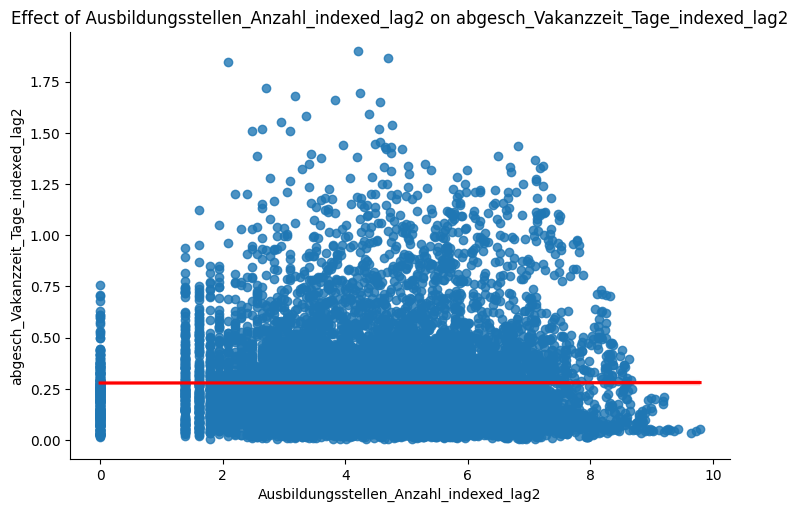

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic scatterplot with regression line
sns.lmplot(
    x='Bewerber_Anzahl_Ins_log_lag2', 
    y='ratio_mean_log', 
    data=indexed_data_filtered, 
    aspect=1.5, 
    line_kws={'color': 'red'}
)

plt.title('Effect of Ausbildungsstellen_Anzahl_indexed_lag2 on abgesch_Vakanzzeit_Tage_indexed_lag2')
plt.xlabel('Ausbildungsstellen_Anzahl_indexed_lag2')
plt.ylabel('abgesch_Vakanzzeit_Tage_indexed_lag2')
plt.show()

Here I plot the same scatterplot but within Berufsgruppen: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Faceted scatterplot with regression line per Berufsgruppe
sns.lmplot(
    x='Bewerber_Anzahl_Ins_log_lag2', 
    y='ratio_mean_log', 
    hue='kldb2010_3_akvs',  # Optional: if you want color by group
    col='kldb2010_3_akvs',  # Facet by each Berufsgruppe
    data=indexed_data_filtered, 
    col_wrap=4,          # Adjust for layout (e.g., 4 plots per row)
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    sharex=False,        # Optional: don't force same x-axis scale
    sharey=False         # Optional: don't force same y-axis scale
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Effect of Ausbildungen on Vakanzzeit by Berufsgruppe')
plt.show()







Here I plot the same graph but within Berufsgruppen and within Bundesländer: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine Berufsgruppe and Bundesland into a new faceting column
indexed_data_filtered['facet_group'] = (
    indexed_data_filtered['kldb2010_3_akvs'].astype(str) + 
    ' | BL: ' + 
    indexed_data_filtered['bland'].astype(str)
)

# Plot: One scatterplot per (Berufsgruppe, Bundesland)
sns.lmplot(
    x='Bewerber_Anzahl_Ins_log_lag2', 
    y='ratio_mean_log', 
    col='facet_group',
    data=indexed_data_filtered,
    col_wrap=4,         # 4 plots per row
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    scatter_kws={'s': 15, 'alpha': 0.6},  # Optional: smaller, transparent points
    sharex=False,
    sharey=False
)

plt.subplots_adjust(top=0.92)
plt.suptitle('Effect of Bewerber on Vakanzzeit by Berufsgruppe and Bundesland', fontsize=16)
plt.show()


Here I plot the second stage of the IV 2SLS regression. 

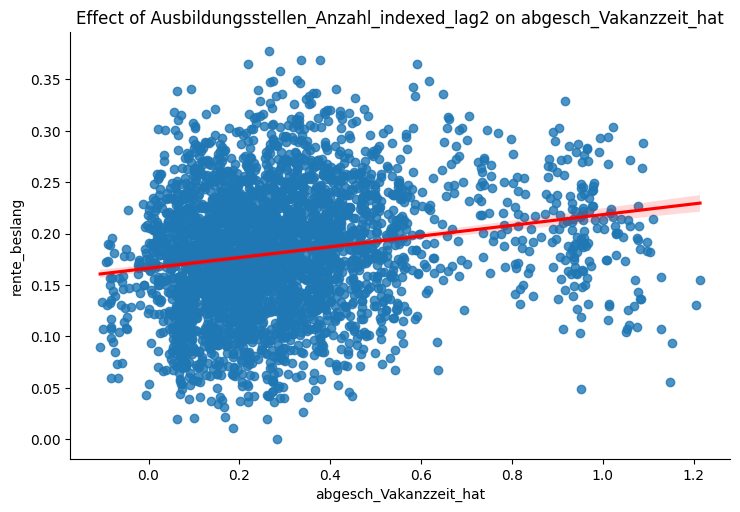

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic scatterplot with regression line
sns.lmplot(
    x='ratio_mean_hat', 
    y='rente_beslang_log', 
    data=indexed_data_filtered, 
    aspect=1.5, 
    line_kws={'color': 'red'}
)

plt.title('Effect of Ausbildungsstellen_Anzahl_indexed_lag2 on abgesch_Vakanzzeit_hat')
plt.xlabel('abgesch_Vakanzzeit_hat')
plt.ylabel('rente_beslang')
plt.show()

Here, I plot the same variables but within Berufsgruppen:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Faceted scatterplot with regression line per Berufsgruppe
sns.lmplot(
    x='ratio_mean_hat', 
    y='rente_beslang_log', 
    hue='kldb2010_3_akvs',  # Optional: if you want color by group
    col='kldb2010_3_akvs',  # Facet by each Berufsgruppe
    data=indexed_data_filtered, 
    col_wrap=4,          # Adjust for layout (e.g., 4 plots per row)
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    sharex=False,        # Optional: don't force same x-axis scale
    sharey=False         # Optional: don't force same y-axis scale
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Effect of Vakanzzeit_Hat on Rentenzugang by Berufsgruppe')
plt.show()


Here I plot abgeschlossene Vakanzzeit in Tagen against the share of early retirees. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Faceted scatterplot with regression line per Berufsgruppe
sns.lmplot(
    x='abgesch_Vakanzzeit_Tage', 
    y='rente_beslang', 
    hue='kldb2010_3_akvs',  # Optional: if you want color by group
    col='kldb2010_3_akvs',  # Facet by each Berufsgruppe
    data=indexed_data_filtered, 
    col_wrap=4,          # Adjust for layout (e.g., 4 plots per row)
    height=4, 
    aspect=1.2,
    line_kws={'color': 'red'},
    sharex=False,        # Optional: don't force same x-axis scale
    sharey=False         # Optional: don't force same y-axis scale
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Effect of Vakanzzeit on Rentenzugang by Berufsgruppe')
plt.show()